In [1]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = "675-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ -194.    7145.   -1810.    7200.    1175.    7123.   -2545.    7257.
  -590.    7238.5   -100.    7234.   -3741.    7605.    3334.    7381.
 -5838.    7690.    5192.    7350.   -4743.    7623.    3613.    7352.
  -998.    7285.    -433.    7265.    3133.5   7355.   -4335.    7712.
 -3066.    7450.     754.    7226.     229.    7210.   -2414.5   7298.
   986.    7222.   -2529.    7342.   -1417.    7338.     512.5   7289.
 -4874.    7685.    4197.    7409.   -6926.    7733.    5999.    7320.
 -5639.    7617.    4268.5   7287.   -1749.    7243.     145.    7180.5
 -4362.    7726.    2396.    7276.5  -1052.    7328.   -1443.    7333.
  1824.    7248.   -3867.    7652.    1763.    7297.   -3266.    7590.
 -1385.    7425.     324.    7377.   -5303.    7754.    4381.    7450.
 -7385.    7776.    6144.5   7323.   -5928.    7602.    4228.    7252.
 -3303.    7636.    1929.    7324.   -1709.    7411.25  -445.    7358.
  1655.    7301.   -3854.    7695.    3695. 

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "general_retarder_function",
            "properties": {"phi": 0, "theta": 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
        # Testing whether generate_system_mueller_matrix can flag this as a non-existent component
        "test_false_type": {
            "type": "test",
            "properties": {"theta": 0, "epsilon": 0}
        },
        # Testing whether generate_system_mueller_matrix can flag epsilon as a
        # non-existent property of rotator
        "test_false_property": {
            "type": "general_retarder_function",
            "properties": {"epsilon": 0}
        }
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

Error: 'test' is not a valid function in pyMuellerMat.common_mm_functions and will be skipped.
[[0.51859792 0.51785552 0.02773924 0.        ]
 [0.51859792 0.51785552 0.02773924 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# TEST: Checking parse_configuration & update_system_mm

In [5]:
test_configuration = {
    'lp': {'theta': 0.0},
    'hwp': {'theta': 0.0},
    'image_rotator': {'theta': 0.0},
    'flc': {'theta': 0.0},
    'wollaston': {'beam': 'o'}
    }

values, keywords = inst.parse_configuration(test_configuration)
print("Values: " + str(values))
print("Keywords: " + str(keywords))

updated_system_mm = inst.update_system_mm(values, keywords, system_mm)
# print(updated_system_mm.evaluate())


Values: [0.0, 0.0, 0.0, 0.0, 'o']
Keywords: [['lp', 'theta'], ['hwp', 'theta'], ['image_rotator', 'theta'], ['flc', 'theta'], ['wollaston', 'beam']]


# Step 4: Creating a dictionary of p0 starting guesses

In [6]:
# Fittin for just the dichroic for now

p0 = {
    "dichroic": {"phi": 0, "theta": 0}
}

p0_values, p0_keywords = inst.parse_configuration(p0)

# Step 5: Running minimize_system_Mueller_matrix

In [7]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

result = inst.minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
    interleaved_stds, configuration_list, s_in = s_in,
    process_dataset = inst.process_dataset, process_errors = inst.process_errors, 
    process_model = inst.process_model)
print(result.x)

p0_values:  [0, 0]
p0_keywords:  [['dichroic', 'phi'], ['dichroic', 'theta']]
[  3.14885203 -55.01162327]


# Step 6: Plot model with best fit

[  3.14885203 -55.01162327]
[['dichroic', 'phi'], ['dichroic', 'theta']]
Model Length:  160
Configurations List Length:  160
Double Differences: [0.11265249215754618, -0.2602889070591442, -0.4504582569571738, -0.3497326203208556, 0.0155424520263131, 0.43122727118240833, 0.6575099084324176, 0.5388174807197943]
Double Differences Length: 8
Double Differences: [0.25869262865090403, 0.18220981527433142, 0.026669394993520223, -0.08558322189684649, -0.06732136810023705, 0.07920656634746923, 0.2694147829704618, 0.3637628722516003]
Double Differences Length: 8
Double Differences: [-0.03385731559854897, 0.2413485306234551, 0.3819463087248322, 0.3673646305681515, 0.23130399568034557, 0.03422336676606126, -0.09632493840678893, -0.10225937953430526, -0.007819528060341845, 0.09428905229881109, 0.1062721329338055, -0.011427412265873285, -0.20873491945811148, -0.37147450927848863, -0.41350111328520345, -0.29975192943770673]
Double Differences Length: 16
Double Differences: [-0.4721073001468037, -0.13

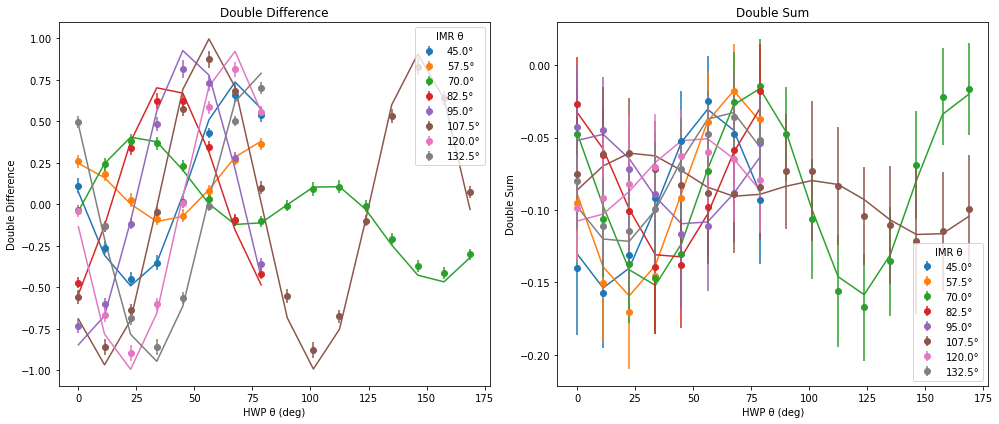

In [8]:
# Generate model with p0 keywords but scipy minimized results
print(result.x)
print(p0_keywords)

if obs_mode != "MBI":
    result.x = [0, 0]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)
print("Model Length: ", len(model))
print("Configurations List Length: ", len(configuration_list))

# print(interleaved_values)

inst.plot_data(interleaved_values, interleaved_stds, model, configuration_list)